Trader Performance vs Market Sentiment
Hyperliquid DEX

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

sns.set_style('whitegrid')
sns.set_palette('Set2')
plt.rcParams.update({'figure.figsize': (13, 5), 'figure.dpi': 110})
os.makedirs('outputs', exist_ok=True)

print('All libraries imported successfully')

All libraries imported successfully


In [ ]:
DATA PREPARATION

In [7]:
#load datasets
sentiment_df = pd.read_csv('sentiment_regimes.csv')
trader_df = pd.read_csv('historical_data.csv')

In [14]:
#strip whitespace
sentiment_df.columns = sentiment_df.columns.str.strip()
trader_df.columns    = trader_df.columns.str.strip()

In [15]:
print('SENTIMENT DATA')
print(f'  Rows    : {len(sentiment_df):,}')
print(f'  Columns : {len(sentiment_df.columns)}')
print(f'  Names   : {sentiment_df.columns.tolist()}')
print('  Missing values:')
print(sentiment_df.isnull().sum().to_string())
print(f'  Duplicates: {sentiment_df.duplicated().sum()}')
sentiment_df.head(3)

SENTIMENT DATA
  Rows    : 2,644
  Columns : 4
  Names   : ['timestamp', 'value', 'classification', 'date']
  Missing values:
timestamp         0
value             0
classification    0
date              0
  Duplicates: 0


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


In [16]:
print('TRADER DATA')
print(f'  Rows    : {len(trader_df):,}')
print(f'  Columns : {len(trader_df.columns)}')
print(f'  Names   : {trader_df.columns.tolist()}')
print('  Missing values:')
print(trader_df.isnull().sum().to_string())
print(f'  Duplicates: {trader_df.duplicated().sum()}')
trader_df.head(3)

TRADER DATA
  Rows    : 211,224
  Columns : 16
  Names   : ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
  Missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
  Duplicates: 0


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


In [17]:
#remove duplicates
s_before = len(sentiment_df)
t_before = len(trader_df)
sentiment_df.drop_duplicates(inplace=True)
trader_df.drop_duplicates(inplace=True)
print(f'Duplicates removed - Sentiment: {s_before - len(sentiment_df)}, Trader: {t_before - len(trader_df)}')

Duplicates removed - Sentiment: 0, Trader: 0


In [18]:
# rename trader and sentiment columns
trader_df.rename(columns={
    'Account'         : 'account',
    'Coin'            : 'symbol',
    'Execution Price' : 'exec_price',
    'Size Tokens'     : 'size_tokens',
    'Size USD'        : 'size_usd',
    'Side'            : 'side',
    'Timestamp IST'   : 'timestamp_ist',
    'Start Position'  : 'start_position',
    'Direction'       : 'direction',
    'Closed PnL'      : 'closed_pnl',
    'Transaction Hash': 'tx_hash',
    'Order ID'        : 'order_id',
    'Crossed'         : 'crossed',
    'Fee'             : 'fee',
    'Trade ID'        : 'trade_id',
    'Timestamp'       : 'timestamp_utc',
}, inplace=True)

sentiment_df.rename(columns={
    'classification': 'sentiment',
    'value'         : 'fg_value',
    'date'          : 'date_str',
    'timestamp'     : 'ts_unix',
}, inplace=True)

print('Sentiment columns:', sentiment_df.columns.tolist())
print('Trader columns   :', trader_df.columns.tolist())

Sentiment columns: ['ts_unix', 'fg_value', 'sentiment', 'date_str']
Trader columns   : ['account', 'symbol', 'exec_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'tx_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp_utc']


In [21]:
#sentiment date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date_str'], utc=True, errors='coerce').dt.date
if sentiment_df['date'].isna().all():
    sentiment_df['date'] = pd.to_datetime(sentiment_df['ts_unix'], unit='s', utc=True).dt.date
    print('Used unix fallback for sentiment dates')

#trader date
trader_df['date'] = pd.to_datetime(trader_df['timestamp_ist'], utc=True, errors='coerce').dt.date
if trader_df['date'].isna().all():
    trader_df['date'] = pd.to_datetime(trader_df['timestamp_utc'], utc=True, errors='coerce').dt.date
    print('Used timestamp_utc fallback for trader dates')

In [24]:
#convert timestamps
for col in ['closed_pnl', 'size_usd', 'size_tokens', 'exec_price', 'start_position', 'fee']:
    trader_df[col] = pd.to_numeric(trader_df[col], errors='coerce')

# Drop rows with no closed PnL (open/pending positions)
before = len(trader_df)
trader_df.dropna(subset=['closed_pnl'], inplace=True)
print(f'Removed {before - len(trader_df):,} rows with null closed_pnl')

# Standardize sentiment label to Title Case
sentiment_df['sentiment'] = sentiment_df['sentiment'].str.strip().str.title()

print('Sentiment counts:')
print(sentiment_df['sentiment'].value_counts())

Removed 0 rows with null closed_pnl
Sentiment counts:
sentiment
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


Build daily metrics per Trader

In [25]:
# Binary flags for win and long direction
trader_df['is_win']  = (trader_df['closed_pnl'] > 0).astype(int)
trader_df['is_long'] = trader_df['side'].str.lower().str.contains('buy|long', na=False).astype(int)

# Aggregate to daily level per trader
daily = trader_df.groupby(['account', 'date']).agg(
    daily_pnl      = ('closed_pnl', 'sum'),
    num_trades     = ('closed_pnl', 'count'),
    avg_trade_size = ('size_usd',   'mean'),
    total_volume   = ('size_usd',   'sum'),
    win_rate       = ('is_win',     'mean'),
    long_ratio     = ('is_long',    'mean'),
    total_fees     = ('fee',        'sum'),
).reset_index()

daily['drawdown_proxy'] = daily['daily_pnl'].clip(upper=0).abs()
daily['net_pnl']        = daily['daily_pnl'] - daily['total_fees'].fillna(0)

print(f'Daily metrics shape : {daily.shape}')
print(f'Unique traders      : {daily["account"].nunique():,}')
print(f'Date range          : {daily["date"].min()} to {daily["date"].max()}')
daily.describe().round(2)

Daily metrics shape : (907, 11)
Unique traders      : 32
Date range          : 2023-01-05 to 2025-12-04


,daily_pnl,num_trades,avg_trade_size,total_volume,win_rate,long_ratio,total_fees,drawdown_proxy,net_pnl
count,907.00,907.00,907.00,907.00,907.00,907.00,907.00,907.00,907.00
mean,6261.26,87.35,7122.51,510313.63,0.35,0.51,109.05,1224.78,6152.21
std,38306.20,184.72,13214.36,2152547.35,0.33,0.36,450.91,9343.80,38237.91
min,-175611.00,1.00,0.00,0.00,0.00,0.00,-4.44,0.00,-175732.23
25%,0.00,10.00,723.03,18507.04,0.00,0.21,3.44,0.00,-3.92
50%,192.91,31.00,2107.25,70586.13,0.31,0.50,14.29,0.00,157.77
75%,1830.37,84.00,7768.53,276269.36,0.58,0.87,66.33,0.00,1714.15
max,533974.66,2617.00,185847.00,51250451.44,1.00,1.00,10554.75,175611.00,533706.37


In [26]:
analysis = daily.merge(
    sentiment_df[['date', 'sentiment', 'fg_value']],
    on='date', how='left'
)

coverage = analysis['sentiment'].notna().mean()
print(f'Rows before drop  : {len(analysis):,}')
print(f'Sentiment coverage: {coverage:.1%}')

analysis.dropna(subset=['sentiment'], inplace=True)
print(f'Rows after drop   : {len(analysis):,}')
print('Sentiment distribution across trader-days:')
print(analysis['sentiment'].value_counts())
analysis.head()

Rows before drop  : 907
Sentiment coverage: 58.4%
Rows after drop   : 530
Sentiment distribution across trader-days:
sentiment
Greed            191
Fear             157
Extreme Greed    112
Neutral           37
Extreme Fear      33
Name: count, dtype: int64


,account,date,daily_pnl,num_trades,avg_trade_size,total_volume,win_rate,long_ratio,total_fees,drawdown_proxy,net_pnl,sentiment,fg_value
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-06-12,-175611.000056,33,36736.362424,1212299.96,0.000000,1.000000,121.229992,175611.000056,-175732.230048,Greed,72.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.000000,177,5089.718249,900880.13,0.000000,0.000000,167.796055,0.000000,-167.796055,Extreme Greed,76.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-03,9482.221441,45,2985.797556,134360.89,0.800000,0.800000,6.718020,0.000000,9475.503421,Greed,74.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,76710.000000,10,185847.000000,1858470.00,0.900000,0.900000,92.923496,0.000000,76617.076504,Greed,60.0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-03-02,101011.685664,839,23593.019857,19794543.66,0.305125,0.417163,2355.038296,0.000000,98656.647368,Fear,26.0


In [29]:
#ANALYSIS

In [30]:
perf = analysis.groupby('sentiment').agg(
    mean_daily_pnl   = ('daily_pnl',     'mean'),
    median_daily_pnl = ('daily_pnl',     'median'),
    pnl_std          = ('daily_pnl',     'std'),
    mean_win_rate    = ('win_rate',       'mean'),
    mean_drawdown    = ('drawdown_proxy', 'mean'),
    trader_days      = ('daily_pnl',      'count'),
).round(4)

print('Performance Summary by Sentiment:')
print(perf.to_string())

Performance Summary by Sentiment:
               mean_daily_pnl  median_daily_pnl     pnl_std  mean_win_rate  mean_drawdown  trader_days
sentiment                                                                                             
Extreme Fear         133.3314            0.0000   1550.0321         0.1735       280.9599           33
Extreme Greed      10329.4078          108.9390  57886.5338         0.3359      1152.1979          112
Fear               11332.6470          396.0627  55888.1227         0.3499       388.3159          157
Greed               3191.7934          147.4458  24776.2317         0.3531      1857.3886          191
Neutral             2017.7498           87.7522   5609.7005         0.3125        76.8210           37


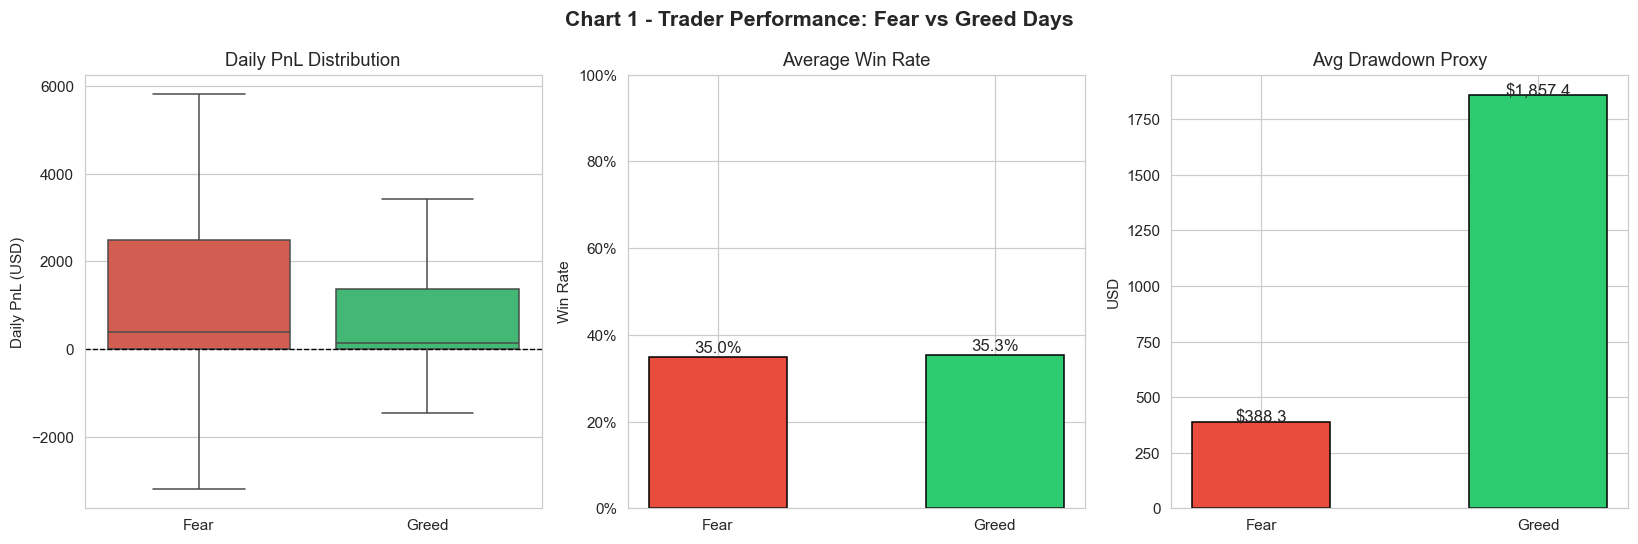

Saved -> outputs/chart1_performance_vs_sentiment.png


In [31]:
ORDER   = ['Fear', 'Greed']
COLORS  = {'Fear': '#e74c3c', 'Greed': '#2ecc71'}
palette = [COLORS[s] for s in ORDER]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Chart 1 - Trader Performance: Fear vs Greed Days', fontsize=14, fontweight='bold')

# PnL boxplot
sns.boxplot(data=analysis, x='sentiment', y='daily_pnl',
            order=ORDER, palette=palette, showfliers=False, ax=axes[0])
axes[0].axhline(0, color='black', lw=0.9, ls='--')
axes[0].set_title('Daily PnL Distribution')
axes[0].set_ylabel('Daily PnL (USD)')
axes[0].set_xlabel('')

# Win rate
vals = perf['mean_win_rate'].reindex(ORDER)
bars = axes[1].bar(ORDER, vals, color=palette, edgecolor='black', width=0.5)
axes[1].set_title('Average Win Rate')
axes[1].set_ylabel('Win Rate')
axes[1].set_ylim(0, 1)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
for b in bars:
    axes[1].text(b.get_x()+b.get_width()/2, b.get_height()+0.01,
                 f'{b.get_height():.1%}', ha='center', fontsize=11)

# Drawdown
vals2 = perf['mean_drawdown'].reindex(ORDER)
bars2 = axes[2].bar(ORDER, vals2, color=palette, edgecolor='black', width=0.5)
axes[2].set_title('Avg Drawdown Proxy')
axes[2].set_ylabel('USD')
for b in bars2:
    axes[2].text(b.get_x()+b.get_width()/2, b.get_height()+0.5,
                 f'${b.get_height():,.1f}', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('outputs/chart1_performance_vs_sentiment.png', bbox_inches='tight', dpi=150)
plt.show()
print('Saved -> outputs/chart1_performance_vs_sentiment.png')

In [32]:
behavior = analysis.groupby('sentiment').agg(
    avg_trades_per_day = ('num_trades',     'mean'),
    avg_trade_size_usd = ('avg_trade_size', 'mean'),
    avg_long_ratio     = ('long_ratio',     'mean'),
    avg_daily_volume   = ('total_volume',   'mean'),
).round(4)

print('Behavior Summary by Sentiment:')
print(behavior.to_string())

Behavior Summary by Sentiment:
               avg_trades_per_day  avg_trade_size_usd  avg_long_ratio  avg_daily_volume
sentiment                                                                              
Extreme Fear              70.4848           7641.1047          0.6567       290310.3042
Extreme Greed             50.1875           7027.9763          0.4653       162712.1453
Fear                      88.3376           7518.4496          0.5390       507480.1978
Greed                     59.1204           7029.6068          0.5425       298669.1924
Neutral                   74.4865           5763.6246          0.4500       322690.5732


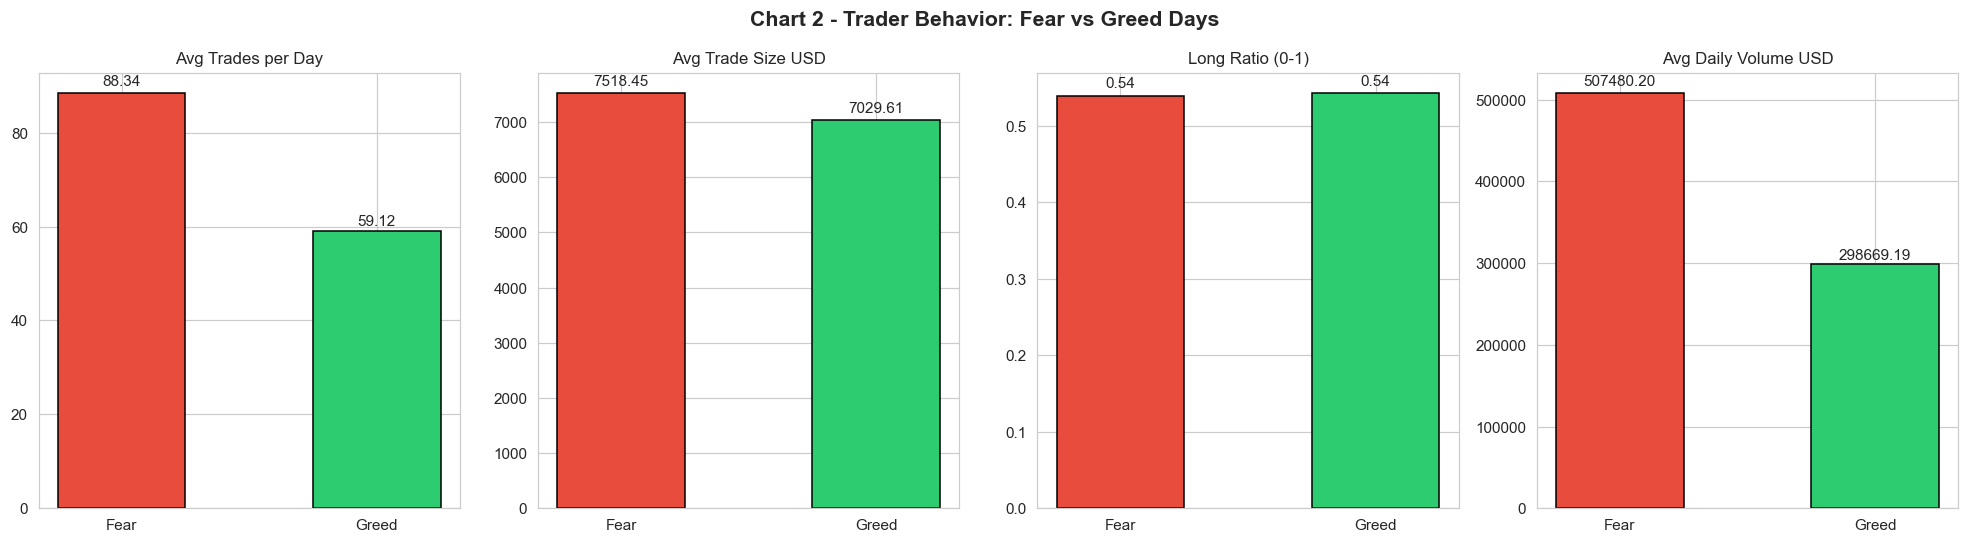

Saved -> outputs/chart2_behavior_vs_sentiment.png


In [33]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle('Chart 2 - Trader Behavior: Fear vs Greed Days', fontsize=14, fontweight='bold')

metrics = [
    ('avg_trades_per_day', 'Avg Trades per Day'),
    ('avg_trade_size_usd', 'Avg Trade Size USD'),
    ('avg_long_ratio',     'Long Ratio (0-1)'),
    ('avg_daily_volume',   'Avg Daily Volume USD'),
]

for ax, (col, label) in zip(axes, metrics):
    vals = behavior[col].reindex(ORDER)
    bars = ax.bar(ORDER, vals, color=palette, edgecolor='black', width=0.5)
    ax.set_title(label, fontsize=11)
    for b in bars:
        ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.02,
                f'{b.get_height():.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('outputs/chart2_behavior_vs_sentiment.png', bbox_inches='tight', dpi=150)
plt.show()
print('Saved -> outputs/chart2_behavior_vs_sentiment.png')

In [34]:
# Build all-time trader profiles
profiles = analysis.groupby('account').agg(
    total_pnl      = ('daily_pnl',      'sum'),
    pnl_std        = ('daily_pnl',      'std'),
    avg_win_rate   = ('win_rate',       'mean'),
    avg_trade_size = ('avg_trade_size', 'mean'),
    avg_num_trades = ('num_trades',     'mean'),
    total_days     = ('daily_pnl',      'count'),
).reset_index()
profiles['pnl_std'] = profiles['pnl_std'].fillna(0)

# Segment A: Trade-size (leverage proxy)
q33 = profiles['avg_trade_size'].quantile(0.33)
q67 = profiles['avg_trade_size'].quantile(0.67)
profiles['size_segment'] = pd.cut(
    profiles['avg_trade_size'],
    bins=[-0.01, q33, q67, profiles['avg_trade_size'].max()+1],
    labels=['Low Size', 'Medium Size', 'High Size'], duplicates='drop'
)

# Segment B: Trade frequency
profiles['freq_segment'] = pd.cut(
    profiles['avg_num_trades'],
    bins=[-0.01, 3, 10, profiles['avg_num_trades'].max()+1],
    labels=['Infrequent (<=3)', 'Moderate (4-10)', 'Frequent (>10)'], duplicates='drop'
)

# Segment C: Win rate consistency
profiles['consistency'] = pd.cut(
    profiles['avg_win_rate'],
    bins=[-0.01, 0.40, 0.60, 1.01],
    labels=['Inconsistent (<40%)', 'Moderate (40-60%)', 'Consistent (>60%)']
)

for seg in ['size_segment', 'freq_segment', 'consistency']:
    print(f'\n{seg}:')
    print(profiles[seg].value_counts().to_string())


size_segment:
size_segment
Low Size       11
High Size      11
Medium Size    10

freq_segment:
freq_segment
Frequent (>10)      27
Moderate (4-10)      4
Infrequent (<=3)     1

consistency:
consistency
Inconsistent (<40%)    20
Moderate (40-60%)       9
Consistent (>60%)       3


In [35]:
# Segment profitability summary
for seg in ['size_segment', 'freq_segment', 'consistency']:
    print(f'\n{"="*50}')
    print(f'  {seg.upper()}')
    print('='*50)
    summary_seg = profiles.groupby(seg)['total_pnl'].agg(
        Count='count', Mean='mean', Median='median', Std='std'
    ).round(2)
    print(summary_seg.to_string())


  SIZE_SEGMENT
              Count       Mean    Median        Std
size_segment                                       
Low Size         11   34199.39  12245.91   60477.39
Medium Size      10  209829.78  24321.71  453014.46
High Size        11  104574.31   2075.02  286518.01

  FREQ_SEGMENT
                  Count       Mean    Median        Std
freq_segment                                           
Infrequent (<=3)      1       0.00      0.00        NaN
Moderate (4-10)       4    1012.53    883.15     942.21
Frequent (>10)       27  134102.16  27717.90  327718.57

  CONSISTENCY
                     Count       Mean     Median        Std
consistency                                                
Inconsistent (<40%)     20   99330.21   14583.90  327642.02
Moderate (40-60%)        9  143784.21   12245.91  315047.48
Consistent (>60%)        3  114715.48  142583.70  103427.83


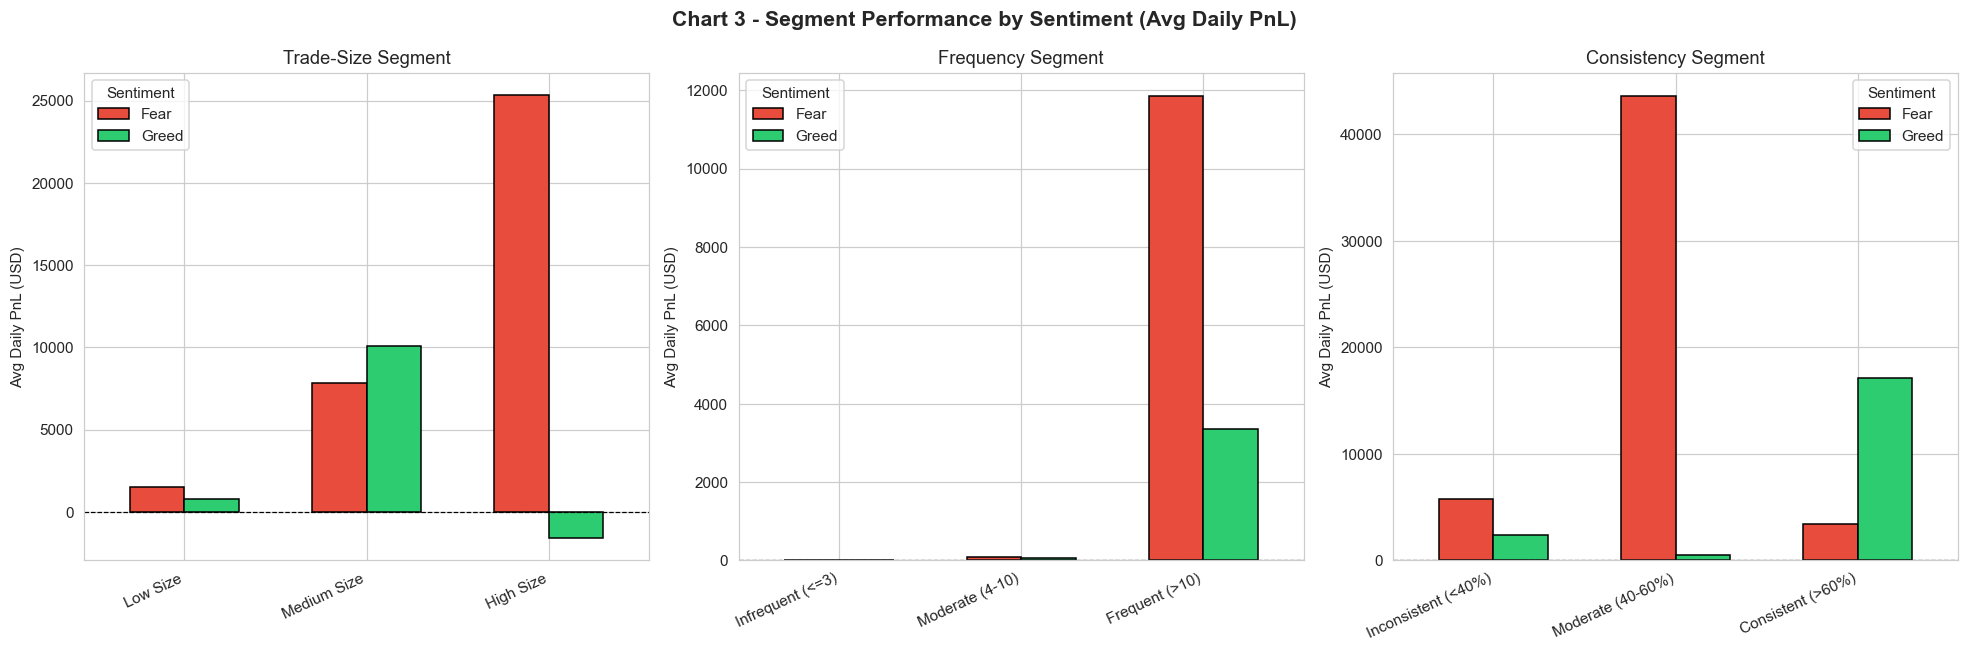

Saved -> outputs/chart3_segments_vs_sentiment.png


In [37]:
# Merge segments back into analysis for sentiment cross-tab
merged_seg = analysis.merge(
    profiles[['account','size_segment','freq_segment','consistency']],
    on='account', how='left'
)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Chart 3 - Segment Performance by Sentiment (Avg Daily PnL)',
             fontsize=14, fontweight='bold')

segs = [
    ('size_segment', 'Trade-Size Segment'),
    ('freq_segment', 'Frequency Segment'),
    ('consistency',  'Consistency Segment'),
]

for ax, (seg, title) in zip(axes, segs):
    pivot = (merged_seg.groupby([seg, 'sentiment'])['daily_pnl']
             .mean().unstack('sentiment').reindex(columns=ORDER))
    pivot.plot(kind='bar', ax=ax, color=['#e74c3c','#2ecc71'],
               edgecolor='black', width=0.6)
    ax.set_title(title)
    ax.set_ylabel('Avg Daily PnL (USD)')
    ax.set_xlabel('')
    ax.axhline(0, color='black', lw=0.8, ls='--')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
    ax.legend(title='Sentiment')

plt.tight_layout()
plt.savefig('outputs/chart3_segments_vs_sentiment.png', bbox_inches='tight', dpi=150)
plt.show()
print('Saved -> outputs/chart3_segments_vs_sentiment.png')

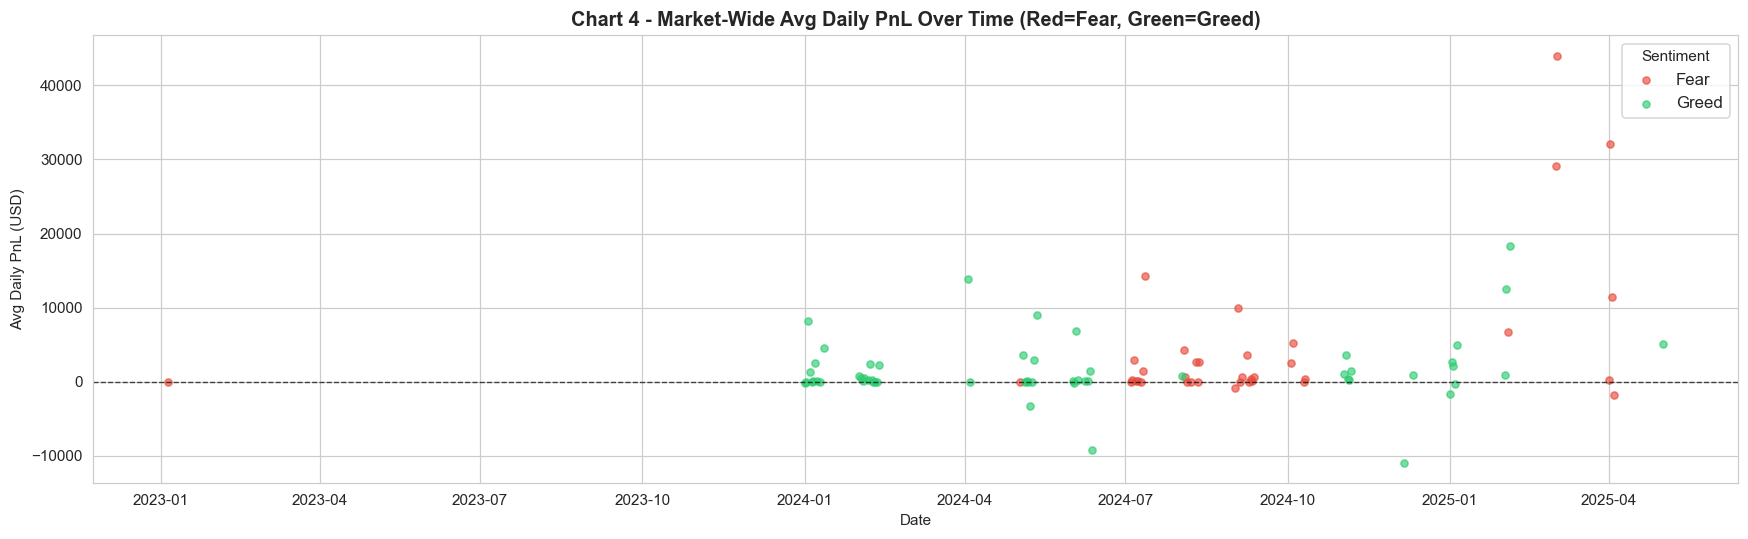

Saved -> outputs/chart4_pnl_timeline.png


In [38]:
timeline = (analysis.groupby(['date','sentiment'])['daily_pnl']
            .mean().reset_index(name='avg_pnl'))
timeline['date'] = pd.to_datetime(timeline['date'])
timeline.sort_values('date', inplace=True)

fig, ax = plt.subplots(figsize=(16, 5))
for senti, color in [('Fear','#e74c3c'), ('Greed','#2ecc71')]:
    sub = timeline[timeline['sentiment'] == senti]
    ax.scatter(sub['date'], sub['avg_pnl'],
               color=color, alpha=0.65, s=22, label=senti)

ax.axhline(0, color='black', lw=0.9, ls='--', alpha=0.7)
ax.set_title('Chart 4 - Market-Wide Avg Daily PnL Over Time (Red=Fear, Green=Greed)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Avg Daily PnL (USD)')
ax.legend(title='Sentiment', fontsize=11)
plt.tight_layout()
plt.savefig('outputs/chart4_pnl_timeline.png', bbox_inches='tight', dpi=150)
plt.show()
print('Saved -> outputs/chart4_pnl_timeline.png')

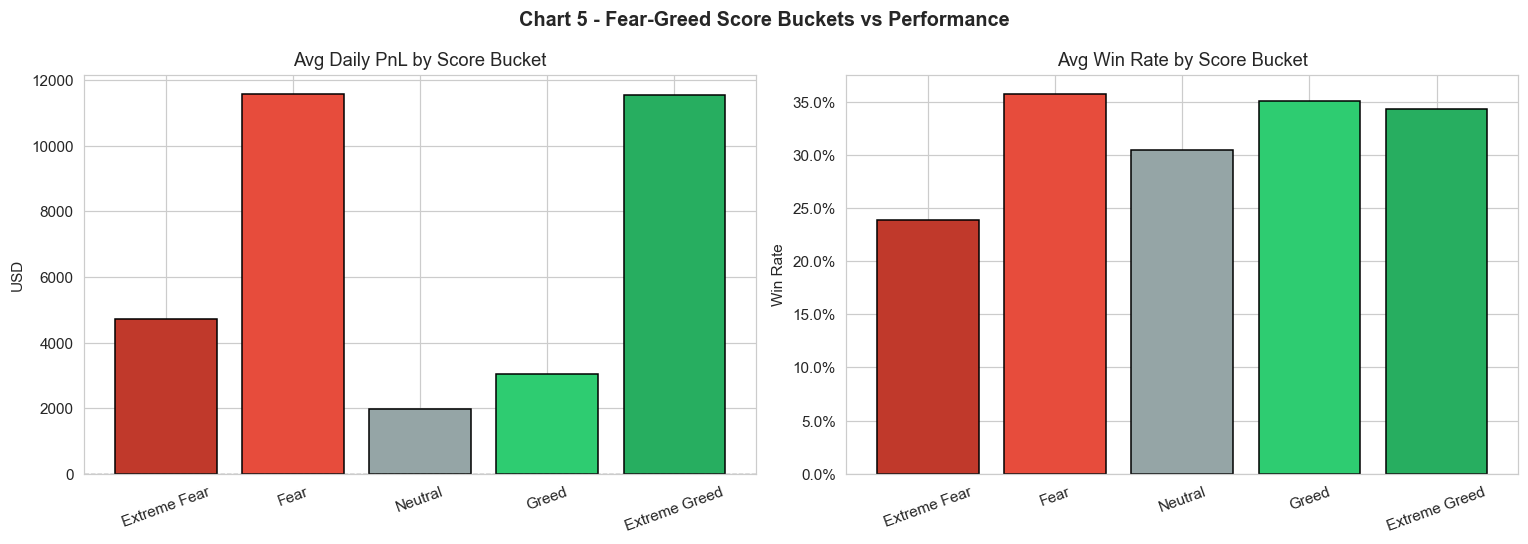

Saved -> outputs/chart5_fg_buckets.png


In [39]:
analysis['fg_bucket'] = pd.cut(
    analysis['fg_value'],
    bins=[0, 25, 45, 55, 75, 100],
    labels=['Extreme Fear','Fear','Neutral','Greed','Extreme Greed']
)

bucket_perf = analysis.groupby('fg_bucket').agg(
    avg_pnl      = ('daily_pnl', 'mean'),
    avg_win_rate = ('win_rate',  'mean'),
    count        = ('daily_pnl', 'count')
).reset_index()

bucket_colors = ['#c0392b','#e74c3c','#95a5a6','#2ecc71','#27ae60']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Chart 5 - Fear-Greed Score Buckets vs Performance', fontsize=13, fontweight='bold')

axes[0].bar(bucket_perf['fg_bucket'].astype(str), bucket_perf['avg_pnl'],
            color=bucket_colors, edgecolor='black')
axes[0].axhline(0, color='black', lw=0.8, ls='--')
axes[0].set_title('Avg Daily PnL by Score Bucket')
axes[0].set_ylabel('USD')
axes[0].tick_params(axis='x', rotation=20)

axes[1].bar(bucket_perf['fg_bucket'].astype(str), bucket_perf['avg_win_rate'],
            color=bucket_colors, edgecolor='black')
axes[1].set_title('Avg Win Rate by Score Bucket')
axes[1].set_ylabel('Win Rate')
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.savefig('outputs/chart5_fg_buckets.png', bbox_inches='tight', dpi=150)
plt.show()
print('Saved -> outputs/chart5_fg_buckets.png')

In [40]:
# Master evidence table
evidence = analysis.groupby('sentiment').agg(
    avg_pnl        = ('daily_pnl',      'mean'),
    pct_positive   = ('daily_pnl',      lambda x: (x>0).mean()),
    avg_win_rate   = ('win_rate',       'mean'),
    avg_trade_size = ('avg_trade_size', 'mean'),
    avg_long_ratio = ('long_ratio',     'mean'),
    avg_num_trades = ('num_trades',     'mean'),
    avg_drawdown   = ('drawdown_proxy', 'mean'),
).round(4)

print('Full Evidence Table:')
print(evidence.T.to_string())

Full Evidence Table:
sentiment       Extreme Fear  Extreme Greed        Fear      Greed    Neutral
avg_pnl             133.3314     10329.4078  11332.6470  3191.7934  2017.7498
pct_positive          0.4242         0.5714      0.6306     0.6283     0.5676
avg_win_rate          0.1735         0.3359      0.3499     0.3531     0.3125
avg_trade_size     7641.1047      7027.9763   7518.4496  7029.6068  5763.6246
avg_long_ratio        0.6567         0.4653      0.5390     0.5425     0.4500
avg_num_trades       70.4848        50.1875     88.3376    59.1204    74.4865
avg_drawdown        280.9599      1152.1979    388.3159  1857.3886    76.8210


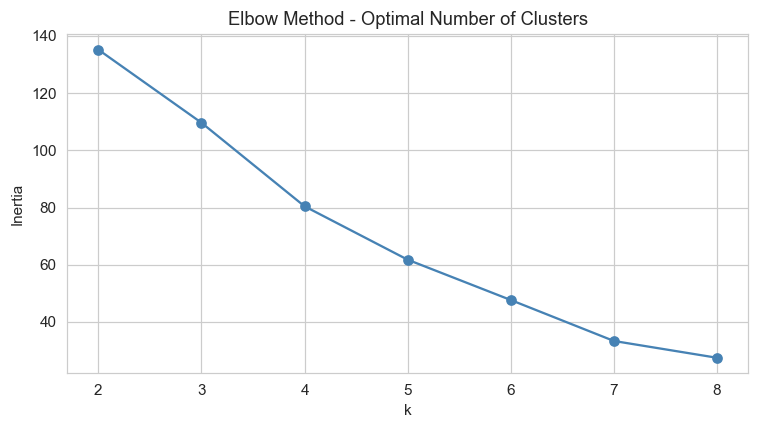

In [41]:
features_for_cluster = ['total_pnl','pnl_std','avg_win_rate',
                        'avg_trade_size','avg_num_trades','total_days']
X_raw = profiles[features_for_cluster].fillna(0)

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Elbow method
inertias = []
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(range(2,9), inertias, marker='o', color='steelblue')
plt.title('Elbow Method - Optimal Number of Clusters')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.tight_layout()
plt.savefig('outputs/chart6_elbow.png', bbox_inches='tight', dpi=150)
plt.show()

In [42]:
K = 4
km_final = KMeans(n_clusters=K, random_state=42, n_init=10)
profiles['cluster'] = km_final.fit_predict(X_scaled)

cluster_summary = profiles.groupby('cluster').agg(
    count          = ('account',        'count'),
    avg_total_pnl  = ('total_pnl',      'mean'),
    avg_win_rate   = ('avg_win_rate',   'mean'),
    avg_trade_size = ('avg_trade_size', 'mean'),
    avg_num_trades = ('avg_num_trades', 'mean'),
).round(2)

print('Cluster Profiles:')
print(cluster_summary.to_string())

# Label each cluster based on dominant feature
cluster_labels = {}
cluster_labels[cluster_summary['avg_total_pnl'].idxmax()]  = 'High Performers'
cluster_labels[cluster_summary['avg_num_trades'].idxmax()] = 'Hyperactive Traders'
cluster_labels[cluster_summary['avg_trade_size'].idxmax()] = 'Whale Traders'
for i in range(K):
    if i not in cluster_labels:
        cluster_labels[i] = 'Casual Traders'

profiles['archetype'] = profiles['cluster'].map(cluster_labels)
print('\nArchetype counts:')
print(profiles['archetype'].value_counts())

Cluster Profiles:
         count  avg_total_pnl  avg_win_rate  avg_trade_size  avg_num_trades
cluster                                                                    
0            2      203503.11          0.57         2693.48          406.59
1           27       27216.67          0.32         7414.19           55.29
2            1      965588.75          0.42        37473.10          310.75
3            2      758681.77          0.28        10824.95           39.20

Archetype counts:
archetype
Casual Traders         29
Hyperactive Traders     2
Whale Traders           1
Name: count, dtype: int64


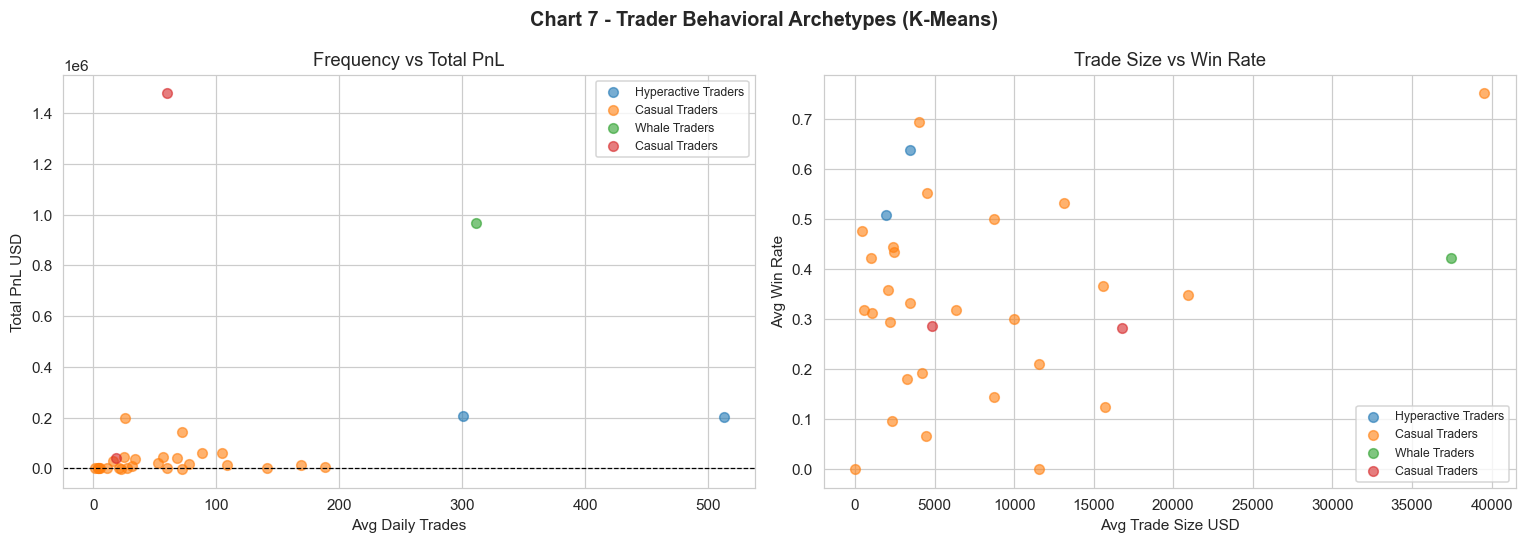

Saved -> outputs/chart7_archetypes.png


In [44]:
palette_c = sns.color_palette('tab10', K)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Chart 7 - Trader Behavioral Archetypes (K-Means)', fontsize=13, fontweight='bold')

for cid, grp in profiles.groupby('cluster'):
    lbl = cluster_labels.get(cid, f'Cluster {cid}')
    axes[0].scatter(grp['avg_num_trades'], grp['total_pnl'],
                    label=lbl, alpha=0.6, s=40, color=palette_c[cid])
axes[0].set_xlabel('Avg Daily Trades')
axes[0].set_ylabel('Total PnL USD')
axes[0].set_title('Frequency vs Total PnL')
axes[0].axhline(0, color='black', lw=0.8, ls='--')
axes[0].legend(fontsize=8)
for cid, grp in profiles.groupby('cluster'):
    lbl = cluster_labels.get(cid, f'Cluster {cid}')
    axes[1].scatter(grp['avg_trade_size'], grp['avg_win_rate'],
                    label=lbl, alpha=0.6, s=40, color=palette_c[cid])
axes[1].set_xlabel('Avg Trade Size USD')
axes[1].set_ylabel('Avg Win Rate')
axes[1].set_title('Trade Size vs Win Rate')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.savefig('outputs/chart7_archetypes.png', bbox_inches='tight', dpi=150)
plt.show()
print('Saved -> outputs/chart7_archetypes.png')